In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The article

> This article will show how to build the classiifer. Will contain a run through of what we did without all the nitty gritty.

In [ ]:
import boto3
from io import BytesIO
import matplotlib.pyplot as plt

from pokedexr.scraper import *
from pokedexr.imgaug import *

Use some functions we wrote to scrape information from Bulbabpedia. First get lists of cards that we want:

In [ ]:
cards = {
        # note `**` is dictionary unpacking operator
        **fetch_card_list('GX_Starter_Decks_(TCG)',req_decks=['Fire Charizard-GX Deck', 'Lightning Raichu-GX Deck']),
        **fetch_card_list('Sky_Legend_(TCG)'),
        **fetch_card_list('Full_Metal_Wall_(TCG)')
}

In [ ]:
len(cards)

143

## Fetch metadata

Pull all the data

In [ ]:
update_card_details(cards)

100%|██████████| 143/143 [03:09<00:00,  1.32s/it]


In Japan we aquired two [GX starter Decks](https://bulbapedia.bulbagarden.net/wiki/GX_Starter_Decks_(TCG)) (the Fire Charizard-GX and Lightning Raichu-GX Decks) and a couple of packs of cards which seem to be from the [Full Metal Wall](https://bulbapedia.bulbagarden.net/wiki/Full_Metal_Wall_(TCG)) and [Sky Legend](https://bulbapedia.bulbagarden.net/wiki/Sky_Legend_(TCG)) Expansion Packs.

The problem is constrained by only needing to be able to recognise these cards in the first instance.I imagine that a neural network would tackle the problem in the same way as my son does: and he doesn't translate the Japanese. Instead he has learnt what various pokemon look like from watching the TV-series and then can recognise those pokemon by the illustration on the cards. I dare say he could memorise the moves for the pokemon two, so the requirement to have the rules in english is for me!



# Why multiple images

So, two different artworks for the same character. One of these is from a promotional pack. There are some intracies here with card numbers and versions. But to my human eye these both look like a Charmander. Like looking at two photos of different dogs of the same breed. So I think I'll keep them.

We'll gather and store the actual images later and for now just collect these urls for each card in our list.

# Prepairing the Pokemon TCG images for training a Neural Network

## Assesing the similarity of our data set to typical image classification data sets

So we have a set of labelled images of Pokemon Cards that can form a training set. However there are some practical problems with using the set as it is. 

When introducing image classification using Deep Learning, fast.ai uses a set of labelled images containing photos of dogs and cats of different breeds. This is the Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 featuring 12 cat breeds and 25 dogs breeds. They show how to build an image classifier that learns to correctly label an image with the animal breed. 

I imagined our Pokemon card classification problem as being similar to this with the different Pokemon being analogous to the different dog breeds. But now that we collated our labelled images of pokemon cards I better check that these assumptions about the similarity of the problem, and specifically of the datasets, still hold true.  

Let's load up that Pet Breeds dataset and have a look at it. If you have taken the fast.ai course you will be familair with it.

[autoreload of pokedexr.scraper failed: Traceback (most recent call last):
  File "/Users/wooduk/projects/pokemon/penv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/wooduk/projects/pokemon/penv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/wooduk/.pyenv/versions/3.8.1/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/wooduk/.pyenv/versions/3.8.1/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/wooduk/projects/pokemon/pokedexr/nbs/pokedexr/scraper.py", line 288, in <module>
    def fetch_card_img_s3(

The classes found in the dataset and the count of number of images beloning to that class:
Counter({'abyssinian': 203, 'siamese': 200, 'chihuahua': 200, 'german_shorthaired': 200, 'bombay': 200, 'bengal': 200, 'japanese_chin': 200, 'havanese': 200, 'yorkshire_terrier': 200, 'boxer': 200, 'keeshond': 200, 'english_setter': 200, 'american_pit_bull_terrier': 200, 'maine_coon': 200, 'wheaten_terrier': 200, 'egyptian_mau': 200, 'miniature_pinscher': 200, 'beagle': 200, 'great_pyrenees': 200, 'leonberger': 200, 'english_cocker_spaniel': 200, 'saint_bernard': 200, 'birman': 200, 'shiba_inu': 200, 'sphynx': 200, 'american_bulldog': 200, 'pug': 200, 'samoyed': 200, 'russian_blue': 200, 'ragdoll': 200, 'persian': 200, 'british_shorthair': 200, 'pomeranian': 200, 'newfoundland': 200, 'basset_hound': 200, 'scottish_terrier': 199, 'staffordshire_bull_terrier': 191})
Extracting sample of images...


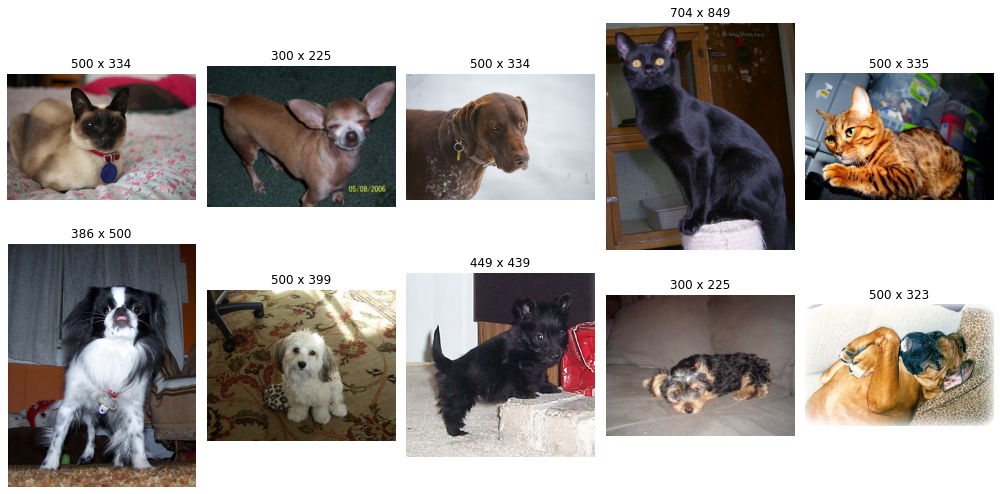

In [ ]:
# fetch the data and extract the file names 
## data at https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet
# !mkdir -p /Users/wooduk/.fastai/data
# !cd /Users/wooduk/.fastai/data
# !wget -c https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
# !tar -tf oxford-iiit-pet.tgz > oxford-iiit-pet.files.txt

from pathlib import Path
import os
from collections import Counter
import matplotlib.pyplot as plt

pth=Path(f"{os.environ['HOME']}/.fastai/data/")
with open(pth/'oxford-iiit-pet.files.txt','r') as f:
    filelist = f.read().split('\n')
    filelistf = filter(lambda s: '/images/' in s, filelist)
    classlist = ['_'.join(f.split('/')[-1].split('_')[:-1]).lower() for f in filelistf]
    classlist = filter(lambda s: len(s)>0, classlist)
    
    print("The classes found in the dataset and the count of number of images beloning to that class:")
    print(Counter(classlist))

    f,ax = plt.subplots(2,5, figsize=(14,7))
    
    print("Extracting sample of images...")
    # Load a few images
    for i,fn in enumerate(list(filelist)[2:12]):
        if not Path(fn).exists():
            !tar -zxvf {pth/'oxford-iiit-pet.tgz'} {fn} > /dev/null
            
        with open(fn,'rb') as imf:
            img=plt.imread(imf)
            a=ax[i//5,i%5]
            a.imshow(img)
            a.set_title(f'{img.shape[1]} x {img.shape[0]}')
            a.axis('off')
            
    plt.tight_layout()  

We can see that are about 200 examples for each breed of animal in the dataset. 

Looking at some of the images in this pet breed dataset I imagine our pokemon card classification problem will be easier because of the nature of the images. It seems intutive that the cartoon-like features of the pokemon images will be simpler to learn and distinguish than those of different dog breeds. Also I would expect variations between dogs of the same breed, while notionally we are always looking a photograph of the same drawing on a pokemon card*. 

But this is, of course, to make many assumptions about how a Neural Net might solve the problem. It may not focus on the depictions of the Pokemon at all.

First there are some more practical differences between the Oxford-IIIT dataset and our Pokemon TCG Card dataset that prevent us from jumping straight into training a network on our data.

Unlike the pets dataset, where there are multiple example photographs for each breed, for many cards we have only 1 labelled image. This will prevent us from splitting our labelled data into meaningful training and validation sets. If we randomly put, say, 20% of our images into a validation set there is a good chance that for many of the pokemon cards the network will have seen zero examples during training. That's the first problem.

The second problem is about the images we collected. In the animal breed data set the images that are expected to be fed to the classiifer for predictions are similar to those used for training. The animals are mostly in different natural environments. The classifier has had the chance during the learning process to learn to ignore those background environments and focus on the features of the animals (one presumes). My intention is to take a photograph of a pokemon card, during a game, and feed it to the classifier. But this is not what we have in our training dataset. Instead we have nice clean images of the artwork of pokemon cards. I can imagine whn I take real photos of cards, the cards will not look so perfect: I will get cards at different angles, under different lighting conditions, different backgrounds behind the cards, Thumbs!

On the fast.ai course a suggested method of increasing the amount of available data is to do data augmentation - tweaking and adjusting source images to effectively create more examples for the classifier to learn from. We will follow the same line of attack here.

Our augmentation problem is something encountered in trainign self-driving cars. While I am not doing it to avoid unbalanced datsets (well ours is so unbalanced that we can't use it to train).

Fastai augments images anyway when training the model, but wee ned to do some augmentations first then fed them in.

### augmentation examples

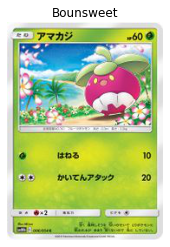

In [ ]:
src_img = fetch_card_img_s3('Bounsweet/180px-BounsweetUnifiedMinds17.jpg',bucket='pokedexproject')
plt.imshow(src_img); plt.gca().axis('off'); plt.gca().set_title('Bounsweet');

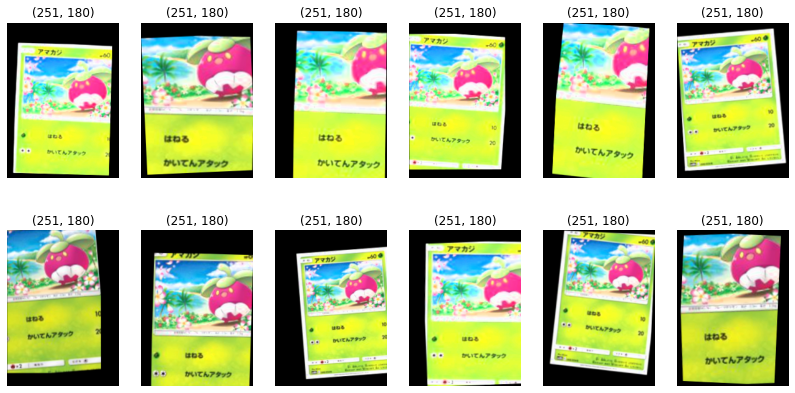

In [ ]:
N_AUGMENTED_IMAGES = 12; _COLS = 6; f,ax = plt.subplots(2,_COLS, figsize=(14,7))

for i in range(N_AUGMENTED_IMAGES):
    
    img = transform_image(src_img,
                          ang_range=10,
                          shear_range=2,
                          trans_range=70,
                          scale_range=0.4, 
                          brightness=0.3
                         )
    a=ax[i//_COLS,i%_COLS]
    
    a.imshow(img)
    a.set_title(img.shape[0:2])
    a.axis('off')

That black background doesn't look so ~hot~ realistic. Perhaps I can graft in some backgrounds onto the black spaces.

I manually found a few images that could represent tables, parts of rooms etc and saved them to GDrive and made them publicly accesible. Let's fetch them here and then write a bit of code to graft them onto the example images.

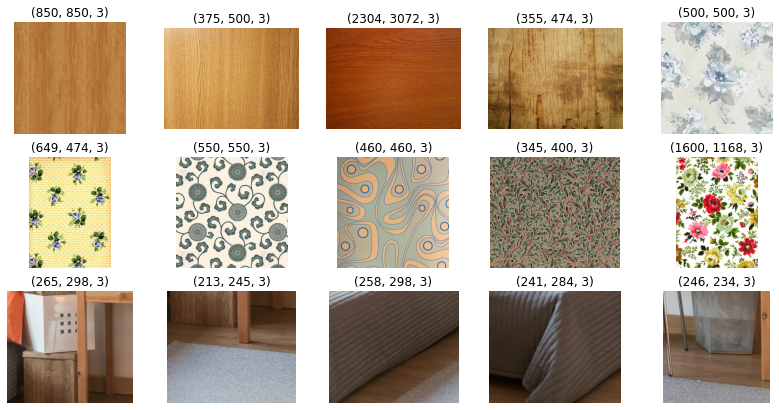

In [ ]:
background_images = fetch_background_images()
f,ax = plt.subplots(3,5,figsize=(14,7))
for i,bkgimg in enumerate(background_images):
    a=ax[i//5,i%5]
    a.imshow(bkgimg)
    a.set_title(bkgimg.shape)
    a.axis('off')

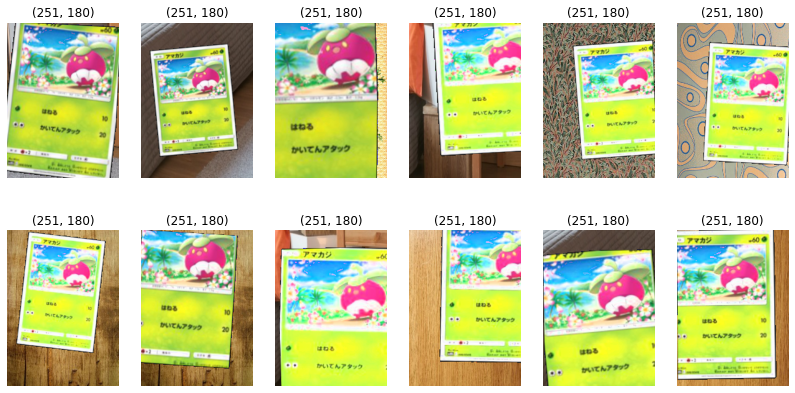

In [ ]:

N_AUGMENTED_IMAGES = 12
_COLS = 6
f,ax = plt.subplots(2,_COLS, figsize=(14,7))

for i in range(N_AUGMENTED_IMAGES):
    
    img = transform_image(src_img,
                          ang_range=10,
                          shear_range=2,
                          trans_range=70,
                          scale_range=0.4, 
                          brightness=0.3
                         )
    a=ax[i//_COLS,i%_COLS]
    
    a.imshow(apply_random_background(img,background_images))
    a.set_title(img.shape[0:2])
    a.axis('off')

In [ ]:

for card_name,card in cards.items():
    print(f"{card_name}")
    augment_card_and_save(card, n_images_out = 3, to=Path('.'))


Charmander


TypeError: 'NoneType' object is not iterable